In [1]:
# 1 Imports
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from keras import Sequential
from keras import layers
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

In [ ]:
# TODO List
    # create models
    # train models
    # make predictions and perform validation
    # robust visuals

In [31]:
# 2 Load Datasets
df_nlr = pd.read_csv("raw_nuclear/nlr.csv")
df_ura = pd.read_csv("raw_nuclear/ura.csv")
df_crak = pd.read_csv("raw_oil_and_gas/crak.csv")
df_fcg = pd.read_csv("raw_oil_and_gas/fcg.csv")
df_pxe = pd.read_csv("raw_oil_and_gas/pxe.csv")
df_icln = pd.read_csv("raw_renewable/icln.csv")
df_smog = pd.read_csv("raw_renewable/smog.csv")
df_tan = pd.read_csv("raw_renewable/tan.csv")

repaired_col = "Repaired?"
df_nlr = df_nlr.drop(columns=[repaired_col]).fillna(0)
df_ura = df_ura.drop(columns=[repaired_col]).fillna(0)
df_crak = df_crak.drop(columns=[repaired_col]).fillna(0)
df_fcg = df_fcg.drop(columns=[repaired_col]).fillna(0)
df_pxe = df_pxe.drop(columns=[repaired_col]).fillna(0)
df_icln = df_icln.drop(columns=[repaired_col]).fillna(0)
df_smog = df_smog.drop(columns=[repaired_col]).fillna(0)
df_tan = df_tan.drop(columns=[repaired_col]).fillna(0)

df_nlr['Date'] = pd.to_datetime(df_nlr['Date'])
df_nlr["day"] = df_nlr["Date"].dt.day
df_nlr["weekday"] = df_nlr["Date"].dt.weekday
df_nlr["month"] = df_nlr["Date"].dt.month
df_nlr = df_nlr.drop(columns=["Date"]).fillna(0)
df_ura['Date'] = pd.to_datetime(df_ura['Date'])
df_crak['Date'] = pd.to_datetime(df_crak['Date'])
df_fcg['Date'] = pd.to_datetime(df_fcg['Date'])
df_pxe['Date'] = pd.to_datetime(df_pxe['Date'])
df_icln['Date'] = pd.to_datetime(df_icln['Date'])
df_smog['Date'] = pd.to_datetime(df_smog['Date'])
df_tan['Date'] = pd.to_datetime(df_tan['Date'])


In [32]:
# 3 Create time frame based subsets
def create_sequences(data, window_size):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data.iloc[i:i+window_size])
        y.append(data.iloc[i+window_size])
    return np.array(X), np.array(y)

def time_based_subsets(df):
    subsets = []
    #row 2013 is the last date of 2023, 12/29/2023
    #row 756 is start of 2019
    #row 505 is start of 2018
    #row 254 is start of 2017
    #row 2 is start of 2016
    #all of these -2 bc 0 indexing and bc title row already seperated out in pd df
    #scaler = MinMaxScaler()
    subsets.append(df.iloc[0:2011]) #8 year time frame
    subsets.append(df.iloc[252:2011]) #7 year time frame
    subsets.append(df.iloc[503:2011]) #6 year time frame
    subsets.append(df.iloc[754:2011]) #5 year time frame
    subsets.append(df.iloc[2012:2262]) # 2024 only
    X, y = [], []
    x1, y1 = create_sequences(subsets[0], 20)
    x1 = x1.reshape((x1.shape[0], x1.shape[1], 9))
    x2, y2 = create_sequences(subsets[1], 20)
    x2 = x2.reshape((x2.shape[0], x2.shape[1], 9))
    x3, y3 = create_sequences(subsets[2], 20)
    x3 = x3.reshape((x3.shape[0], x3.shape[1], 9))
    x4, y4 = create_sequences(subsets[3], 20)
    x4 = x4.reshape((x4.shape[0], x4.shape[1], 9))
    X.append(x1)
    X.append(x2)
    X.append(x3)
    X.append(x4)
    y.append(y1)
    y.append(y2)
    y.append(y3)
    y.append(y4)
    return subsets, X, y

nlr_sets, nlr_X, nlr_y = time_based_subsets(df_nlr)
'''ura_sets, ura_X, ura_y = time_based_subsets(df_ura)
crak_sets, crak_X, crak_y = time_based_subsets(df_crak)
fcg_sets, fcg_X, fcg_y = time_based_subsets(df_fcg)
pxe_sets, pxe_X, pxe_y = time_based_subsets(df_pxe)
icln_sets, icln_X, icln_y = time_based_subsets(df_icln)
smog_sets, smog_X, smog_y = time_based_subsets(df_smog)
tan_sets, tan_X, tan_y = time_based_subsets(df_tan)'''



'ura_sets, ura_X, ura_y = time_based_subsets(df_ura)\ncrak_sets, crak_X, crak_y = time_based_subsets(df_crak)\nfcg_sets, fcg_X, fcg_y = time_based_subsets(df_fcg)\npxe_sets, pxe_X, pxe_y = time_based_subsets(df_pxe)\nicln_sets, icln_X, icln_y = time_based_subsets(df_icln)\nsmog_sets, smog_X, smog_y = time_based_subsets(df_smog)\ntan_sets, tan_X, tan_y = time_based_subsets(df_tan)'

In [35]:
# 4 Initial Model Setup
rf = RandomForestClassifier(n_estimators=200, n_jobs=-1, random_state=42)

svm_model = svm.SVC(kernel='rbf', C=1.0, gamma='scale', random_state=42)

sequence_length = 2012
#this is temp placeholder
lstm_model = Sequential()
lstm_model.add(layers.LSTM(units=64, return_sequences=False, input_shape=(sequence_length, 9)))
#lstm_model.add(layers.LSTM(units=64, return_sequences=False))
lstm_model.add(layers.Dense(units=32, activation='relu'))
lstm_model.add(layers.Dense(units=9))
lstm_model.compile(optimizer='adam',
              loss='mse')

gru_model = Sequential()
gru_model.add(layers.GRU(units=128, activation='tanh', input_shape=(sequence_length, 9))) # GRU layer
gru_model.add(layers.Dense(units=1)) # Output layer for a single value prediction
gru_model.compile(optimizer='adam', loss='mse')

In [36]:
# 5 Model Testing
history = lstm_model.fit(
    nlr_X[3], nlr_y[3],
    epochs=100,
    batch_size=32,
    validation_split=0.1,
    verbose=1
)

Epoch 1/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 5152545.0000 - val_loss: 289161664.0000
Epoch 2/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4097159.5000 - val_loss: 289114944.0000
Epoch 3/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4300861.0000 - val_loss: 289030912.0000
Epoch 4/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4623537.0000 - val_loss: 288892096.0000
Epoch 5/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 3994270.5000 - val_loss: 288599264.0000
Epoch 6/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 3379288.5000 - val_loss: 288299232.0000
Epoch 7/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 3988361.5000 - val_loss: 287915776.0000
Epoch 8/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 4088247.7500 - val_loss: 287489280.0000
Epoch 9/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4850830.5000 - val_loss: 287022400.0000
Epoch 10/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 5052167.5000 - val_loss: 286526432.0000
Epoch 1

In [37]:
# 6 make predictions
def predict_future_points(model, last_seq, num_predictions=20):
    """
    last_seq: DataFrame or numpy array of shape (window_size, num_features)
    """
    # Convert to numpy always
    current_sequence = np.asarray(last_seq).astype(np.float32)

    # Ensure correct shape: (1, window_size, num_features)
    current_sequence = current_sequence.reshape(1, current_sequence.shape[0], current_sequence.shape[1])

    predictions = []

    for _ in range(num_predictions):
        # Predict next point
        next_pred = model.predict(current_sequence, verbose=0)

        # Inverse scale (model predicts 1 feature)
        '''next_pred = scaler.inverse_transform(
            np.concatenate([next_pred_scaled, 
                            np.zeros((1, current_sequence.shape[2]-1))], axis=1)
        )[0, 0]'''

        predictions.append(next_pred)

        # Add predicted scaled value into sequence for further prediction
        next_pred_full = np.concatenate(
            [next_pred, np.zeros((1, current_sequence.shape[2]-1))], axis=1
        )

        # Update sequence: remove first timestep, append predicted value
        current_sequence = np.append(
            current_sequence[:, 1:, :],     # remove first time-step
            next_pred.reshape(1, 1, -1),  # add predicted step
            axis=1
        )

    return predictions

#scaler = MinMaxScaler()
last_seq = nlr_sets[3].iloc[-20:]
future = predict_future_points(lstm_model, last_seq, 50)
#future = scaler.inverse_transform(future_scaled.reshape(-1, 1))

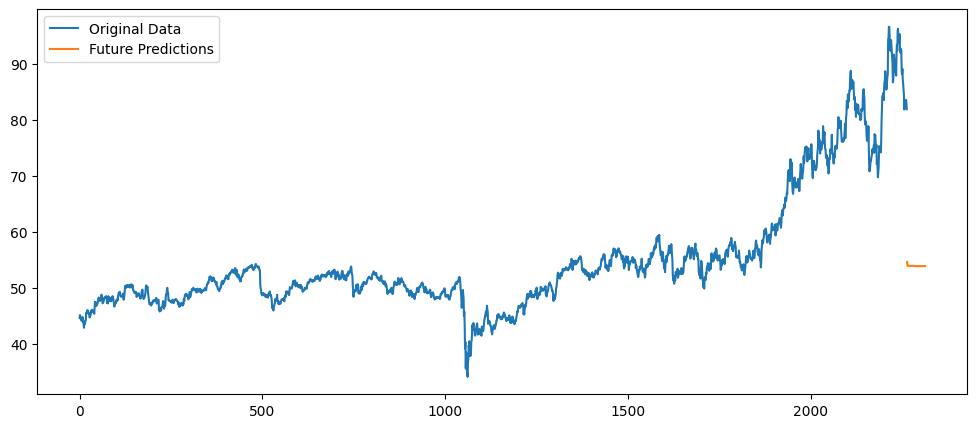

In [48]:
future_feature = np.array([arr[0][0] for arr in future])
plt.figure(figsize=(12,5))
plt.plot(df_nlr['Close'], label="Original Data")
plt.plot(range(len(df_nlr), len(df_nlr) + len(future)), future_feature, label="Future Predictions")
plt.legend()
plt.show()